### **Download dataset from Roboflow**

In [1]:
!pip install roboflow

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="bCFryYsEHyQ3MJEGY9Ml")
project = rf.workspace("projetos-fensd").project("analise-de-buracos-na-rua")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


### **Show data sample**

In [3]:
import cv2
import random
import glob as glob
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

In [4]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0]+bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [5]:
class_names = ['Buraco']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        
        # denormalize the coordinates
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        # Text width and height
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [6]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

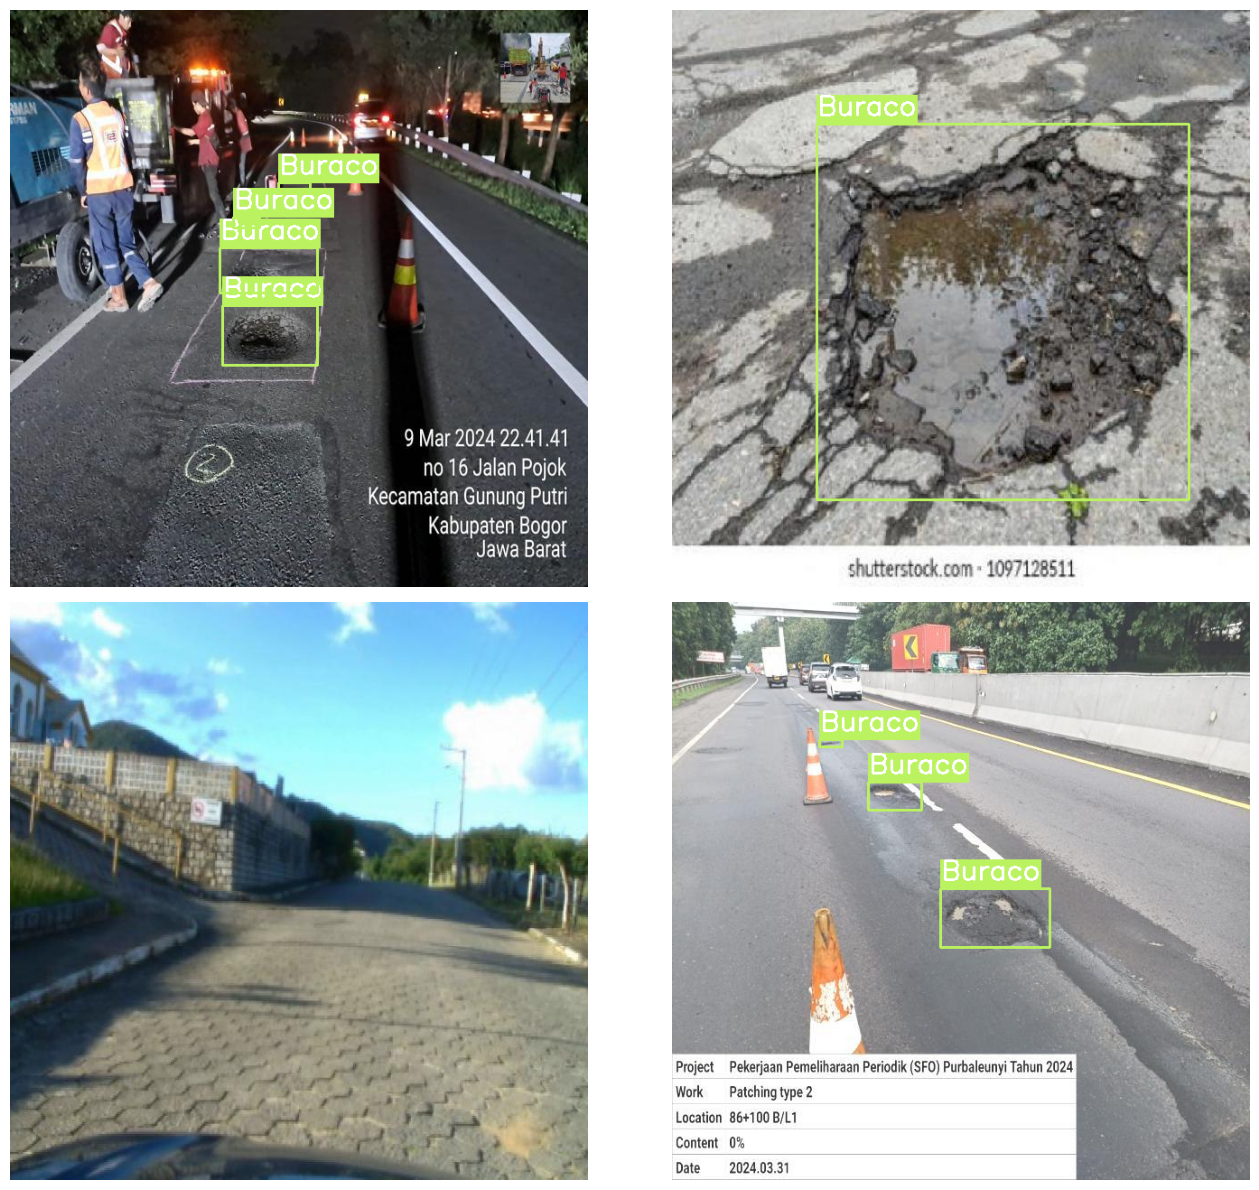

In [7]:
plot(image_paths='/kaggle/working/Analise-de-buracos-na-rua-1/train/images/*',
    label_paths='/kaggle/working/Analise-de-buracos-na-rua-1/train/labels/*',
    num_samples=4,
)

### **Apply YOLOV11**

In [8]:
!pip install ultralytics

In [9]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO("yolo11n.pt")

In [10]:
# Use the model
results = model.train(data="/kaggle/working/Analise-de-buracos-na-rua-1/data.yaml", epochs=100)  # train the model

Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/Analise-de-buracos-na-rua-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

2024-11-04 10:24:35,536	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-04 10:24:36,137	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/Analise-de-buracos-na-rua-1/train/labels.cache... 1904 images, 208 backgrounds, 0 corrupt: 100%|██████████| 1904/1904 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/Analise-de-buracos-na-rua-1/valid/labels.cache... 238 images, 30 backgrounds, 0 corrupt: 100%|██████████| 238/238 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.64G      1.438      2.611      1.387         28        640: 100%|██████████| 119/119 [00:28<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]

                   all        238        446      0.422      0.265      0.262      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.64G      1.533      2.053      1.428         58        640: 100%|██████████| 119/119 [00:25<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]

                   all        238        446      0.538      0.487      0.486      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.64G      1.578      1.837      1.461         53        640: 100%|██████████| 119/119 [00:25<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.38it/s]

                   all        238        446      0.667      0.487      0.547       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.65G      1.546      1.705      1.464         58        640: 100%|██████████| 119/119 [00:25<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]

                   all        238        446       0.54      0.491      0.473      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.63G      1.524      1.657      1.445         47        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.71it/s]

                   all        238        446       0.61      0.556      0.553      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.67G       1.51      1.592      1.421         57        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]

                   all        238        446      0.691      0.576      0.621      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.68G      1.448      1.493      1.385         62        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]

                   all        238        446       0.63      0.581      0.629      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.67G      1.437      1.446      1.368         33        640: 100%|██████████| 119/119 [00:25<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]

                   all        238        446      0.599      0.584      0.612      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.66G      1.423      1.423      1.372         38        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]

                   all        238        446      0.664      0.621      0.655      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.65G      1.397        1.4      1.344         48        640: 100%|██████████| 119/119 [00:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]

                   all        238        446      0.666      0.531      0.602       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.65G      1.414      1.374      1.354         31        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.00it/s]

                   all        238        446      0.666      0.637      0.677      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.67G      1.337      1.322      1.314         36        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]

                   all        238        446      0.726      0.611      0.665      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.66G      1.366      1.324      1.328         39        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]

                   all        238        446      0.728      0.612       0.69      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.68G      1.344      1.314      1.312         54        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]

                   all        238        446      0.723      0.639      0.681      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.65G      1.325      1.263      1.313         42        640: 100%|██████████| 119/119 [00:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]

                   all        238        446      0.698      0.652      0.701      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.68G      1.323        1.3      1.305         39        640: 100%|██████████| 119/119 [00:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]

                   all        238        446      0.687      0.646      0.704      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.64G      1.318      1.242      1.311         58        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]

                   all        238        446      0.676      0.659      0.679      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.64G      1.299      1.212       1.28         31        640: 100%|██████████| 119/119 [00:25<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]

                   all        238        446      0.727      0.626      0.715      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.63G      1.291       1.25      1.281         41        640: 100%|██████████| 119/119 [00:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]

                   all        238        446      0.622      0.561      0.573      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.65G      1.279      1.224      1.287         46        640: 100%|██████████| 119/119 [00:25<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.89it/s]

                   all        238        446      0.716      0.623      0.684      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.63G       1.25      1.186      1.267         40        640: 100%|██████████| 119/119 [00:25<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]

                   all        238        446       0.74       0.65      0.699      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.63G       1.28      1.182      1.273         43        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]

                   all        238        446      0.632      0.673      0.682      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.65G      1.261      1.158      1.267         37        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]

                   all        238        446      0.736      0.668      0.738       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.67G      1.249      1.169      1.256         38        640: 100%|██████████| 119/119 [00:25<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.38it/s]

                   all        238        446       0.71      0.693      0.725      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.64G      1.199      1.124      1.225         37        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]

                   all        238        446      0.734      0.684      0.747      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.68G      1.223      1.129      1.249         51        640: 100%|██████████| 119/119 [00:25<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]

                   all        238        446      0.717      0.648      0.707      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.68G      1.221      1.119      1.244         48        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.99it/s]

                   all        238        446      0.744      0.693      0.743      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.64G      1.212      1.112      1.238         45        640: 100%|██████████| 119/119 [00:25<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]

                   all        238        446      0.764      0.666      0.737      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.67G      1.197      1.102      1.242         27        640: 100%|██████████| 119/119 [00:25<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]

                   all        238        446      0.732      0.723      0.754      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.63G      1.188      1.077       1.22         36        640: 100%|██████████| 119/119 [00:25<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]

                   all        238        446      0.769      0.626      0.735      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.63G      1.186      1.076      1.225         35        640: 100%|██████████| 119/119 [00:25<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]

                   all        238        446      0.739      0.697      0.737      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.65G      1.184      1.071      1.232         50        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]

                   all        238        446      0.763      0.688      0.747       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.64G      1.218      1.109       1.23         36        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]

                   all        238        446      0.774       0.67       0.75      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.64G      1.196      1.074       1.23         32        640: 100%|██████████| 119/119 [00:25<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]

                   all        238        446      0.724      0.665      0.729      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.63G      1.163      1.042      1.203         33        640: 100%|██████████| 119/119 [00:25<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]

                   all        238        446      0.736      0.676      0.755      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.65G      1.162      1.052      1.211         46        640: 100%|██████████| 119/119 [00:25<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]

                   all        238        446      0.742      0.711      0.732      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.64G      1.161      1.027      1.208         38        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.92it/s]

                   all        238        446      0.739      0.704      0.748      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.63G      1.159      1.026      1.205         38        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]

                   all        238        446      0.768      0.689      0.767      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.68G      1.151      1.012      1.195         45        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]

                   all        238        446      0.746      0.684      0.737      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.62G       1.15      1.021      1.202         39        640: 100%|██████████| 119/119 [00:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]

                   all        238        446      0.734      0.706      0.746      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.67G      1.138      0.998      1.201         49        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]

                   all        238        446      0.764      0.726      0.765      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.63G      1.134     0.9947      1.194         42        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]

                   all        238        446      0.759      0.708      0.764      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.68G      1.121     0.9972      1.175         57        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]

                   all        238        446      0.773      0.711      0.772        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.66G      1.139      0.999      1.183         47        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]

                   all        238        446      0.769        0.7      0.768      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.64G      1.109     0.9646      1.175         37        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.02it/s]

                   all        238        446      0.777      0.691      0.771      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.65G      1.129     0.9894      1.184         42        640: 100%|██████████| 119/119 [00:25<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]

                   all        238        446      0.705      0.742      0.755      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.65G      1.121     0.9733      1.185         68        640: 100%|██████████| 119/119 [00:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.37it/s]

                   all        238        446      0.818      0.677      0.774      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.64G      1.091     0.9393      1.164         28        640: 100%|██████████| 119/119 [00:25<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]

                   all        238        446      0.776      0.682      0.755      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.65G      1.095     0.9472      1.166         44        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]

                   all        238        446      0.815      0.659      0.763      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.65G      1.099     0.9388       1.18         31        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]

                   all        238        446      0.803      0.665      0.762      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.63G      1.081     0.9244      1.164         30        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]

                   all        238        446      0.774      0.709       0.78      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.61G      1.094     0.9388      1.173         40        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]

                   all        238        446      0.768      0.727      0.779      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.65G        1.1     0.9228       1.17         41        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]

                   all        238        446      0.771      0.726      0.784      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.63G      1.065     0.9056      1.151         34        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]

                   all        238        446      0.774      0.731      0.782      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.63G       1.06     0.8951      1.156         44        640: 100%|██████████| 119/119 [00:25<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]

                   all        238        446      0.731      0.751      0.786      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.67G      1.078     0.9068      1.163         43        640: 100%|██████████| 119/119 [00:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.22it/s]

                   all        238        446      0.736      0.738      0.774      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.67G      1.069     0.8828      1.156         37        640: 100%|██████████| 119/119 [00:25<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.45it/s]

                   all        238        446      0.706      0.731      0.774      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.66G       1.08     0.9135      1.158         39        640: 100%|██████████| 119/119 [00:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.42it/s]

                   all        238        446      0.721      0.748      0.786      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.65G      1.082     0.9027      1.159         54        640: 100%|██████████| 119/119 [00:25<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]

                   all        238        446      0.694      0.765       0.77      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.65G      1.051     0.8922      1.139         34        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]

                   all        238        446      0.761      0.707      0.781      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.64G      1.068     0.8757      1.147         53        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]

                   all        238        446      0.759      0.713      0.776      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.65G      1.036     0.8635      1.131         29        640: 100%|██████████| 119/119 [00:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]

                   all        238        446       0.78      0.688      0.771       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.65G      1.048     0.8694      1.131         43        640: 100%|██████████| 119/119 [00:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.01it/s]

                   all        238        446      0.769       0.73      0.794      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.65G      1.048     0.8602       1.14         48        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.31it/s]

                   all        238        446      0.738      0.738      0.783      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.67G      1.022     0.8436      1.137         33        640: 100%|██████████| 119/119 [00:25<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]

                   all        238        446      0.791      0.703      0.779      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.64G      1.034     0.8519      1.128         51        640: 100%|██████████| 119/119 [00:25<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.95it/s]

                   all        238        446      0.734      0.762      0.793      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.65G      1.024     0.8303      1.116         69        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.39it/s]

                   all        238        446      0.766       0.72      0.792      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.64G      1.024     0.8359      1.131         41        640: 100%|██████████| 119/119 [00:25<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]

                   all        238        446      0.762      0.733      0.786      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.67G     0.9921     0.8072       1.11         60        640: 100%|██████████| 119/119 [00:25<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]

                   all        238        446      0.805      0.686      0.778      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.63G     0.9981     0.8051      1.116         41        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.20it/s]

                   all        238        446      0.807      0.673      0.792      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.65G      1.004      0.815      1.116         58        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.14it/s]

                   all        238        446      0.752      0.741      0.791      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.67G      1.005     0.8125      1.103         28        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]

                   all        238        446      0.768      0.713      0.775      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.64G      1.011     0.8072      1.112         40        640: 100%|██████████| 119/119 [00:25<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]

                   all        238        446      0.786      0.706      0.792      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.63G     0.9814     0.7932      1.104         45        640: 100%|██████████| 119/119 [00:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]

                   all        238        446      0.745      0.753      0.787      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.65G     0.9823     0.7882        1.1         54        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]

                   all        238        446      0.818      0.707      0.793      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.64G     0.9867     0.8029      1.102         39        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]

                   all        238        446      0.771      0.776      0.813      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.65G     0.9735     0.7784      1.101         47        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]

                   all        238        446      0.756      0.745      0.792      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.66G     0.9974      0.788      1.105         51        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]

                   all        238        446      0.765      0.745      0.798      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.65G     0.9804     0.7621      1.094         43        640: 100%|██████████| 119/119 [00:25<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]

                   all        238        446       0.79      0.709      0.787      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.68G     0.9613     0.7468      1.087         58        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.77it/s]

                   all        238        446      0.764      0.756      0.788      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.64G     0.9589     0.7512      1.094         49        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.17it/s]

                   all        238        446      0.757      0.748      0.804      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.67G     0.9686     0.7749       1.09         31        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]

                   all        238        446      0.774      0.729      0.792      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.63G     0.9487     0.7475      1.084         45        640: 100%|██████████| 119/119 [00:25<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]

                   all        238        446       0.77      0.738      0.791      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.63G      0.942     0.7515      1.087         46        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.07it/s]

                   all        238        446       0.74      0.771      0.799      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.64G     0.9611     0.7415      1.091         33        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]

                   all        238        446      0.807       0.73      0.805      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.63G     0.9414     0.7274      1.075         34        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]

                   all        238        446      0.807      0.722      0.809      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.63G     0.9335     0.7236      1.081         26        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]

                   all        238        446       0.79      0.722      0.793      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.64G     0.9385     0.7214      1.084         57        640: 100%|██████████| 119/119 [00:25<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]

                   all        238        446       0.78      0.747        0.8      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.64G      0.937     0.7071      1.074         44        640: 100%|██████████| 119/119 [00:25<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]

                   all        238        446      0.769      0.748      0.798      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.65G     0.9142     0.7016      1.064         44        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]

                   all        238        446      0.792      0.751      0.802      0.546


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.63G      0.865     0.6386      1.024         46        640: 100%|██████████| 119/119 [00:25<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]

                   all        238        446       0.79      0.724      0.795      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.63G     0.8439      0.605      1.017         41        640: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]

                   all        238        446      0.786      0.717      0.793       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.66G     0.8283     0.6039      1.001         33        640: 100%|██████████| 119/119 [00:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]

                   all        238        446      0.872      0.677      0.804      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.63G     0.8281     0.6018      1.002         21        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.37it/s]

                   all        238        446      0.775      0.751      0.804      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.63G     0.8328     0.5855      1.008         21        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]

                   all        238        446      0.772       0.76      0.808      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.65G     0.8223     0.5787     0.9996         30        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]

                   all        238        446      0.767       0.76      0.803      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.63G     0.8024      0.572     0.9874         25        640: 100%|██████████| 119/119 [00:25<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]

                   all        238        446      0.756      0.756      0.798      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.63G     0.8076      0.565     0.9918         28        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]

                   all        238        446      0.783      0.735      0.801       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.68G     0.8057     0.5744     0.9879         21        640: 100%|██████████| 119/119 [00:24<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]

                   all        238        446      0.749      0.765      0.797      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.64G     0.8052     0.5583     0.9999         32        640: 100%|██████████| 119/119 [00:24<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]

                   all        238        446      0.766      0.756      0.801      0.551



100 epochs completed in 0.758 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.63it/s]


                   all        238        446      0.804      0.722      0.809      0.555
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train2


### **Prediction**

In [14]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train2/weights/best.pt source='/kaggle/working/Analise-de-buracos-na-rua-1/test/images/po_179_jpg.rf.ad5df95fea1f31d3114bd31a2360b3b0.jpg'

Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /kaggle/working/Analise-de-buracos-na-rua-1/test/images/po_179_jpg.rf.ad5df95fea1f31d3114bd31a2360b3b0.jpg: 640x640 2 Buracos, 11.6ms
Speed: 4.7ms preprocess, 11.6ms inference, 151.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


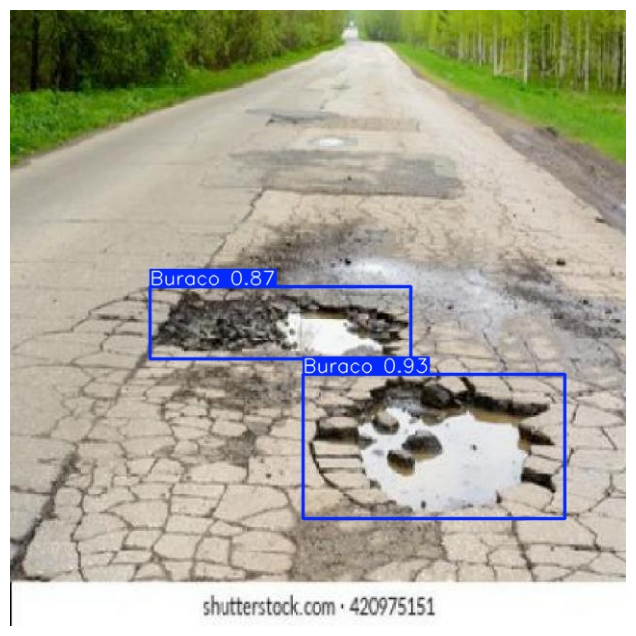

In [15]:
img_path = '/kaggle/working/runs/detect/predict/po_179_jpg.rf.ad5df95fea1f31d3114bd31a2360b3b0.jpg'
img = plt.imread(img_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis(False)
plt.show()